# Preprocessing Pipeline

### Imports

In [4]:
import os.path
import pyxdf
import mne
from os import path
import numpy as np
import matplotlib.pyplot as plt
from tkinter import Tk
from tkinter.filedialog import askdirectory
import glob, os
import promptlib 

### Constants

In [5]:
TIME_OFFSET = -1  # in sec, the event window begins x seconds before the time stamp
DUR = 5 # in sec, duration of the event window in seconds
EVENTS = {
    'Baseline' : None,
    'MI' : 'MI trial marker',
    'PO' : 'Unity.Marker.TargetID'
}
EPOCH_VAR = {
    'TIME_OFFSET' : TIME_OFFSET,
    'DUR' : DUR,
    'EVENTS' : EVENTS
}


### Functions

In [58]:
def select_stream(stream_data, selection='type',desired_type='EEG'):
    
    for stream in stream_data:
        stream_type = stream['info'][selection][0]
        
        if stream_type == desired_type:
            return stream
        else:
            continue

def show_epoch(epochs,n_epochs=10):
    if epochs != None:
        print(epochs)
        print(epochs.events)
        epochs.plot(n_epochs=n_epochs,events=epochs.events, event_id=epochs.event_id)


        
def select_eegs(xdf_files):
    
    eeg_files = []

    for file in xdf_files:
        print('Processing {}'.format(file))
        data,header = pyxdf.load_xdf(file)
        eeg_file = select_stream(data)
        eeg_file['file'] = os.path.basename(os.path.normpath(file))
        eeg_files.append(eeg_file)
    
    return eeg_files

def raw_processing(raw,filtering,fmin=0.1,fmax=40,bad_chs=['M1','M2','EOG']):
    signal = raw.copy()
    signal.info['bads'].extend(bad_chs)

    if filtering == 'rawBPCAR':
        signal = signal.filter(fmin,fmax)
        signal, ref_data = mne.set_eeg_reference(signal, ref_channels='average', copy=True)
    
    return signal
    
def to_mne(data_path, filtering, NB_CHANNELS = 64):
    stream,header = pyxdf.load_xdf(data_path)
    stream_eeg = select_stream(stream)
    ch_names = []
    channels = stream_eeg['info']['desc'][0]['channels'][0]['channel']

    for channel in channels:
        current_label = channel['label'][0]
        if (current_label != 'AUX3') & (current_label != 'TRIGGER'):
            ch_names.append(channel['label'][0])
        else:
            continue

    data = stream_eeg["time_series"].copy().T  # data.shape = (nb_channels, nb_samples)
    data = data[0:64,:] # We do not keep data for AUX3 and TRIGGER
    data *= 1e-6  # convert from uV to V (mne uses V)
    #assert len(data) == NB_CHANNELS      
    sfreq = float(stream_eeg["info"]["nominal_srate"][0])
    ch_types = ['eeg'] * 64
    info = mne.create_info(ch_names, sfreq, ch_types)
    # info = mne.create_info(NB_CHANNELS, sfreq)
    raw = mne.io.RawArray(data, info)

    ### Filtering and CAR
    signal = raw_processing(raw,filtering)
    

    ### Epoch management
    
    file = os.path.basename(os.path.normpath(data_path))
    event_keys = list(EVENTS.keys())
    event_type = [key for key in event_keys if key in file][0]
    
    if event_type == 'PO':
        
        event_id = {
            'Left':1,
            'Right':2,
            'Third':3
        }
        stream_event = select_stream(stream,'name',EVENTS[event_type])
        target_nb = np.array(stream_event['time_series']).squeeze()  # array with target IDs
        t_origin = stream_eeg['time_stamps'][0]
        t_stamps = stream_event['time_stamps'] - t_origin
        annots = mne.Annotations(onset=t_stamps, duration = 0., description=target_nb)
        raw_annotated = signal.copy().set_annotations(annots) 
        eventss, event_idss = mne.events_from_annotations(raw_annotated)
        epochs = mne.Epochs(raw_annotated, eventss, event_id, tmin = -2, tmax = 7, baseline=(-2,0), reject=dict(eeg=400e-6), proj=False, reject_by_annotation=None)
    
    elif event_type == 'MI':
        '''
        t_origin = stream_eeg['time_stamps'][0]
        stream_event = select_stream(stream,'name',EVENTS[event_type])
        time_stamps = stream_event['time_stamps'] - t_origin  # signal begins at 0s
        target_nb = np.array(stream_event['time_series']).squeeze()  # array with target IDs
        TIME_OFFSET = -1
        annots = mne.Annotations(onset=time_stamps, duration=0., description=target_nb)
        rawannot = rawBPCAR.copy().set_annotations(annots)


        #### Create events from annotations

        events, event_id = mne.events_from_annotations(rawannot)
        # print(event_id)
        # print(events)


        #### Create mne.Epochs with events and event_ID
        # also define the event window 

        epochs = mne.Epochs(rawBPCAR, events, event_id, tmin=TIME_OFFSET, tmax=DUR, baseline=(TIME_OFFSET,0), reject=dict(eeg=400e-6))
        '''
        
        stream_event = select_stream(stream,'name',EVENTS[event_type])
        target_nb = np.array(stream_event['time_series']).squeeze()  # array with target IDs
        t_origin = stream_eeg['time_stamps'][0]

        ts_1 = [stream_event['time_stamps'][0] - t_origin +2 + 9* i for i in range(30)]
        ts_2 = [stream_event['time_stamps'][30] - t_origin +2 + 9* i for i in range(30)]
        t_stamps = np.concatenate((ts_1, ts_2))
        t_onset = t_stamps
        annots = mne.Annotations(onset=t_onset, duration = 9, description=target_nb)  
        raw_annotated = signal.copy().set_annotations(annots)
        eventss, event_idss = mne.events_from_annotations(raw_annotated)
        epochs = mne.Epochs(raw_annotated, eventss, event_idss, tmin = -2, tmax = 7, baseline=(-2,0), reject=dict(eeg=400e-6), proj=False, reject_by_annotation=None)


    else:
        
        epochs = None


    return signal, epochs

def read_file(path,filtering='rawBPCAR'):
    
    initial_directory = os.getcwd()
    xdf_files = []
    for file in glob.glob(path+"\*.xdf"):
        xdf_files.append(file)

    EEG_dict = {}
    for file in xdf_files:
        mne_data,epochs = to_mne(file,filtering)
        file_name = os.path.basename(file).split('.')[0]
        EEG_dict[file_name] = {}
        EEG_dict[file_name]['signal'] = mne_data
        EEG_dict[file_name]['Epochs'] = epochs
    
    return EEG_dict
        

### Subject Selection (Hardcoded)

In [5]:
root = Tk()
root.withdraw()

file_path = askdirectory()
print(file_path)
input('press any key to exit')

C:/Users/haiou/Documents/TNE/Python/Data/Group_Realistic_Arm/S01


### EEG streams selection

In [ ]:
EEG_dict = read_file("Data\Group_Realistic_Arm\S01",'rawBPCAR')

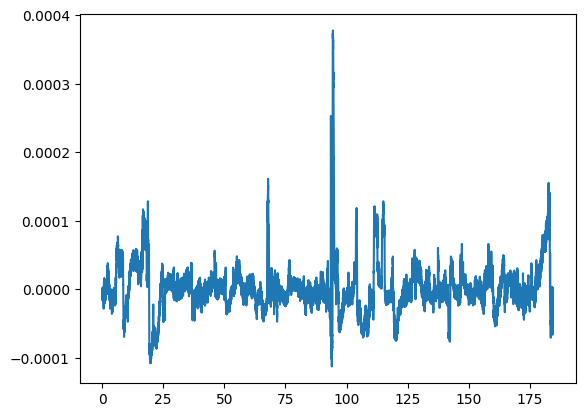

In [97]:
plt.plot(EEG_dict['sub-S01_eegBaselineCE']['rawBPCAR'][1][1],EEG_dict['sub-S01_eegBaselineCE']['rawBPCAR'][1][0][0])
plt.show()

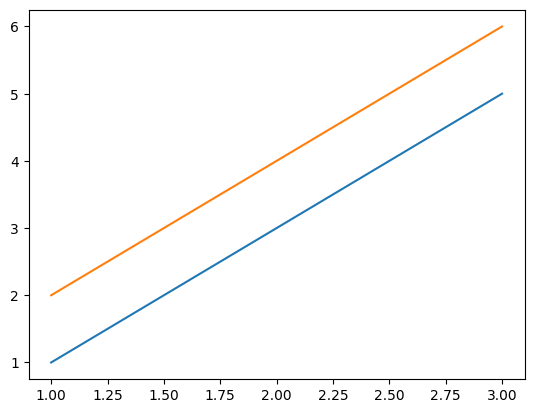

In [96]:

x = [1, 2, 3]
y = np.array([[1, 2], [3, 4], [5, 6]])
plt.plot(x, y)
plt.show()

In [ ]:
mne_data,epochs = to_mne("Data\Group_Realistic_Arm\S01\sub-S01_PO_Block1.xdf")

In [ ]:
show_epoch(epochs)

### Conversion to MNE format

### Saving signals

In [81]:
mne_data.save('Data\Group_Realistic_Arm\S01\PO_test.fif')
epochs.save('Data\Group_Realistic_Arm\S01\PO_epochs.fif')

Writing c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S01\PO_test.fif


C:\Users\haiou\AppData\Local\Temp\ipykernel_9136\3183981645.py:1: RuntimeWarning: This filename (c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S01\PO_test.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save('Data\Group_Realistic_Arm\S01\PO_test.fif')


Closing c:\Users\haiou\Documents\TNE\Python\Data\Group_Realistic_Arm\S01\PO_test.fif
[done]
Using data from preloaded Raw for 1 events and 18001 original time points ...
Using data from preloaded Raw for 22 events and 18001 original time points ...


C:\Users\haiou\AppData\Local\Temp\ipykernel_9136\3183981645.py:2: RuntimeWarning: This filename (Data\Group_Realistic_Arm\S01\PO_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save('Data\Group_Realistic_Arm\S01\PO_epochs.fif')


In [33]:
downloaded_eeg = mne.io.read_raw_fif('sub-S01_eegBaselineCE.fif')

Opening raw data file sub-S01_eegBaselineCE.fif...
Isotrak not found
    Range : 0 ... 369015 =      0.000 ...   184.507 secs
Ready.


C:\Users\haiou\AppData\Local\Temp\ipykernel_23356\1747688115.py:1: RuntimeWarning: This filename (sub-S01_eegBaselineCE.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  downloaded_eeg = mne.io.read_raw_fif('sub-S01_eegBaselineCE.fif')


In [35]:
downloaded_eeg.info['bads']

['M1', 'M2', 'EOG']

### Miscellaneous

In [63]:
import pandas as pd
df = pd.read_csv('Data\previous_recap.csv')

In [84]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

    Unnamed: 0  subject                        group experience bandpass[Hz]  \
0            0  sub-S01          Group_Realistic_Arm     MIpost       1.5-40   
1            1  sub-S01          Group_Realistic_Arm      MIpre       1.5-40   
2            2  sub-S02          Group_Realistic_Arm     MIpost       1.5-40   
3            3  sub-S02          Group_Realistic_Arm      MIpre       1.5-40   
4            4  sub-S02          Group_Realistic_Arm         PO       1.5-40   
5            5  sub-S03          Group_Realistic_Arm     MIpost       1.5-40   
6            6  sub-S03          Group_Realistic_Arm      MIpre       1.5-40   
7            7  sub-S03          Group_Realistic_Arm         PO       1.5-40   
8            8  sub-S04          Group_Realistic_Arm     MIpost       1.5-40   
9            9  sub-S04          Group_Realistic_Arm      MIpre       1.5-40   
10          10  sub-S04          Group_Realistic_Arm         PO       1.5-40   
11          11  sub-S05          Group_R

In [46]:
data,header = pyxdf.load_xdf('Data\S01\sub-S01_MIpre.xdf')

Stream 2: Calculated effective sampling rate 15487.4688 Hz is different from specified rate 500.0000 Hz.
Stream 1: Calculated effective sampling rate 5192.4441 Hz is different from specified rate 500.0000 Hz.


In [71]:
data[2]['info']['desc'][0]['channels'][0]['channel'][0]['label'][0]

[defaultdict(list, {'label': ['FP1'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['FPZ'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['FP2'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['F7'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['F3'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['FZ'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['F4'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['F8'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['FC5'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['FC1'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['FC2'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['FC6'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['M1'], 'type': ['EEG'], 'unit': ['uV']}),
 defaultdict(list, {'label': ['T7'], 'type': ['EEG'], 'un